In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt

import scipy
from scipy import signal

pykat.init_pykat_plotting(fmts=['svg'])

                                              ..-
    PyKat 1.1.244         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [32]:
### Get the DARM Cavity Pole from the shot noise
%run LHO.py
base0= make_LHO()


Pykat parsing does not preserve inline comments. Moving inline
comments before command



In [39]:
result = None
while result is None:
    try:
        base0 = aligo.setup(base0)
        base0.IFO.zero_locks()
        result = 1
    except:
        pass
        print("Ran into a pykat error, trying again")

kat0 = base0.deepcopy()
kat0.parse(kat0.IFO.DARM.transfer())
kat0.parse("qnoisedS NSR 1 $fs nAS")
kat0.removeBlock("locks", False)
kat0.removeBlock("errsigs", False)

out_shotnoise_cp = kat0.IFO.DARM_h.scan_f(linlog='log',lower=1,upper=7000,steps=50)

In [47]:
kat0.IFO.get_tunings()

{'BS': 0.0,
 'ETMX': 0.6779416910977835,
 'ETMY': -0.6783193344533875,
 'ITMX': 0.6801124339641921,
 'ITMY': -0.6801124339641921,
 'PRM': -0.4975985486924858,
 'SRM': -75.79049921070227,
 'keys': {'maxtem': 2, 'phase': 2}}

In [43]:
### Find Cavity pole
sn_dc = out_shotnoise_cp['NSR'][0]
sn_pole = sn_dc/0.7071

pole_index = np.where( out_shotnoise_cp['NSR'] > sn_pole )
pole_index = pole_index[0].min()

cav_pole = out_shotnoise_cp.x[pole_index]

print(cav_pole)

411.781344428977


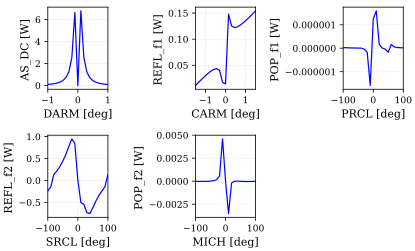

In [48]:
aligo.plot.error_signals(base0, xlimits=(-1, 1), steps=20)

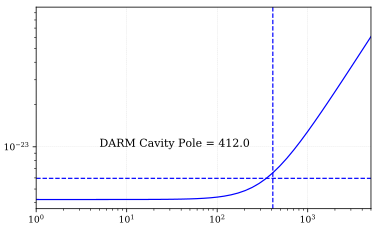

In [49]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.axhline(sn_pole,linestyle='--')
ax.axvline(cav_pole,linestyle='--')
ax.loglog(out_shotnoise_cp.x,abs(out_shotnoise_cp['NSR']))

ax.annotate('DARM Cavity Pole = '+str(round(cav_pole)), xy=(5, 1e-23))

ax.set_xlim(1,5000)
#ax.set_ylim(1e-24,1e-22)

plt.show()

In [50]:
kat = kat0.deepcopy()
kat.IFO.suspend_mirrors_z()

kat.parse(kat.IFO.DARM.transfer())

out = kat.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)

In [51]:
### Load raw Darm data
raw_darm = np.loadtxt('20181030_DARM_PSD.txt')
raw_darm = raw_darm.transpose()
freq_darm = raw_darm[0]
data_darm = raw_darm[1]

# Make the zpk, z = 0.3, p= 30, k=1e-12
z_cal = -2*np.pi*np.array([30.,30.,30.,30.,30.,30.])
p_cal = -2*np.pi*np.array([0.3,0.3,0.3,0.3,0.3,0.3])

_ , zpk_cal = signal.freqresp((z_cal,p_cal,1.e-12), 2*np.pi*freq_darm)

asd_cal = np.abs(zpk_cal)

In [52]:
darm_cal = data_darm * np.abs(asd_cal)
sense = darm_cal/4000

In [ ]:
#Search for sqz angle answer is something like 28.44 degrees

darm_sqz_data = []
sqz_angle = np.arange(0,90,10)

for i in range(len(sqz_angle)):
    kat_sqz = kat.deepcopy()
    kat_sqz.IFO.fix_mirrors()
    kat_sqz.sqz.db = 2
    kat_sqz.sqz.angle = sqz_angle[i]
    kat_sqz.parse(kat.IFO.DARM.transfer())
    out_sqz = kat_sqz.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)
    darm_sqz_data.append(abs(out_sqz['NSR']))
    
ratio=[]
for i in range(len(darm_sqz_data)):
    ratio.append(darm_sqz_data[i][-1]/abs(out['NSR'][-1]))

index = ratio.index(min(ratio))

print(sqz_angle[index])


####
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for i in range(len(sqz_angle)):
    ax.loglog(out.x,darm_sqz_data[i])
    
ax.loglog(out.x,abs(out['NSR']),'--',label='QM Limited sensitivity: No squeezing', linewidth=3)

ax.set_xlim(10,5000)

plt.legend()

plt.show()

In [54]:
sqz_angle = 28.44
kat_sqz = kat.deepcopy()
kat_sqz.sqz.db = 3
kat_sqz.sqz.angle = sqz_angle
kat_sqz.parse(kat.IFO.DARM.transfer())
kat_sqz.parse(kat.IFO.DARM.transfer())
out_sqz = kat_sqz.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)

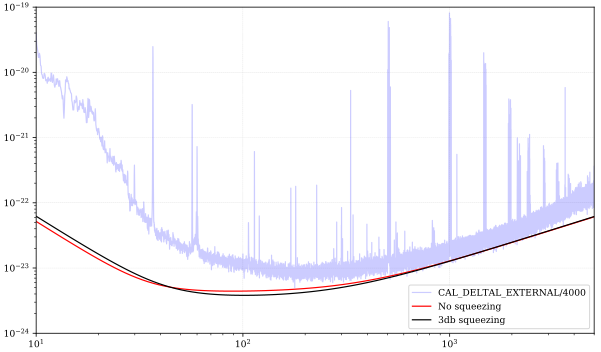

In [55]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)

ax.loglog(freq_darm,sense,alpha=0.2,label='CAL_DELTAL_EXTERNAL/4000')
ax.loglog(out.x,abs(out['NSR']), label='No squeezing')
ax.loglog(out.x,abs(out_sqz['NSR']), label='3db squeezing')

ax.set_xlim(10,5000)
ax.set_ylim(1e-24,1e-19)

plt.legend()
plt.show()

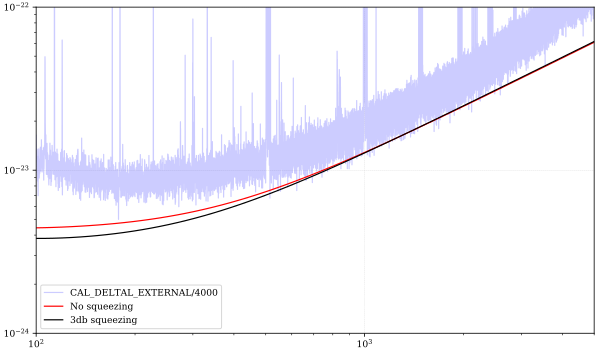

In [56]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)

ax.loglog(freq_darm,sense,alpha=0.2,label='CAL_DELTAL_EXTERNAL/4000')
ax.loglog(out.x,abs(out['NSR']), label='No squeezing')
ax.loglog(out.x,abs(out_sqz['NSR']), label='3db squeezing')

ax.set_xlim(100,5000)
ax.set_ylim(1e-24,1e-22)

plt.legend()
plt.show()